In [134]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from random import randint
import os
import pickle
from tqdm.notebook import tqdm

In [135]:
class Layer:
    def __init__(self):
        self.input = None
        self.output = None

    def forward(self, input):
        raise NotImplementedError

    def backward(self, output_gradient, learning_rate):
        raise NotImplementedError

    def save(self, filename):
        raise NotImplementedError


In [136]:
class Dense(Layer):
    def __init__(self, input_size, output_size):
        self.weights = np.random.randn(output_size, input_size)
        self.bias = np.random.randn(output_size, 1)

    def forward(self, input):
        self.input = input
        return np.dot(self.weights, input) + self.bias

    def backward(self, output_gradient, learning_rate):
        weights_gradient = np.dot(output_gradient, self.input.T)
        input_gradient = np.dot(self.weights.T, output_gradient)
        self.weights -= learning_rate * weights_gradient
        self.bias -= learning_rate * output_gradient
        return input_gradient

class Dropout(Layer):
    def __init__(self, drop_rate):
        self.drop_rate = drop_rate
        self.mask = None

    def forward(self, input):
        self.mask = np.random.rand(*input.shape) > self.drop_rate
        return input * self.mask

    def backward(self, output_gradient, learning_rate):
        return output_gradient * self.mask


In [137]:
class Activation(Layer):
    def __init__(self, activation, activation_prime):
        self.activation = activation
        self.activation_prime = activation_prime

    def forward(self, input):
        self.input = input
        return self.activation(input)

    def backward(self, output_gradient, learning_rate):
        return np.multiply(output_gradient, self.activation_prime(self.input))

class Tanh(Activation):
    @staticmethod
    def activation(x):
        return np.tanh(x)

    @staticmethod
    def activation_prime(x):
        return 1 - np.tanh(x) ** 2

    def __init__(self):
        super().__init__(Tanh.activation, Tanh.activation_prime)

class Sigmoid(Activation):

    @staticmethod
    def activation(x):
        return 1 / (1 + np.exp(-x))

    @staticmethod
    def activation_prime(x):
        sig = Sigmoid.activation(x)
        return sig * (1 - sig)

    def __init__(self):
        super().__init__(Sigmoid.activation, Sigmoid.activation_prime)

class ReLU(Activation):
    @staticmethod
    def activation(x):
        return np.maximum(0, x)

    @staticmethod
    def activation_prime(x):
        return np.where(x > 0, 1, 0)

    def __init__(self):
        super().__init__(ReLU.activation, ReLU.activation_prime)

class Softmax(Activation):
    @staticmethod
    def activation(x):
        exp = np.exp(x)
        return exp / np.sum(exp, axis=0)

    @staticmethod
    def activation_prime(x):
        return 1

    def __init__(self):
        super().__init__(Softmax.activation, Softmax.activation_prime)


In [138]:
class Loss:
    def loss(self, y_true, y_pred):
        raise NotImplementedError()

    def gradient(self, y_true, y_pred):
        raise NotImplementedError()

class MeanSquaredError(Loss):
    def loss(self, y_true, y_pred):
        return np.mean(np.power(y_true - y_pred, 2))

    def gradient(self, y_true, y_pred):
        return 2 * (y_pred - y_true) / y_true.size

class BinaryCrossEntropy(Loss):
    def loss(self, y_true, y_pred):
        epsilon = 1e-15
        return -np.mean(np.multiply(y_true, np.log(y_pred + epsilon)) + np.multiply(1 - y_true, np.log(1 - y_pred + epsilon)))

    def gradient(self, y_true, y_pred):
        epsilon = 1e-15
        return np.divide(y_pred - y_true, np.multiply(y_pred + epsilon, 1 - y_pred + epsilon))

class CategoricalCrossEntropy(Loss):
    def loss(self, y_true, y_pred):
        epsilon = 1e-15
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
        return -np.mean(np.sum(y_true * np.log(y_pred), axis=1))

    def gradient(self, y_true, y_pred):
        epsilon = 1e-15
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
        return y_pred - y_true


In [139]:
class Optimizer:
    def __init__(self, learning_rate):
        self.learning_rate = learning_rate

    def update(self, layer):
        raise NotImplementedError()

class SGD:
    def __init__(self, learning_rate=0.01):
        self.learning_rate = learning_rate

    def update(self, weights, gradients):
        for w, grad in zip(weights, gradients):
            w -= self.learning_rate * grad

class Adam:
    def __init__(self, learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7):
        self.learning_rate = learning_rate
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.epsilon = epsilon
        self.m = None  # First moment vector
        self.v = None  # Second moment vector
        self.t = 0     # Time step

    def update(self, weights, gradients):
        if self.m is None:
            self.m = [np.zeros_like(w) for w in weights]
        if self.v is None:
            self.v = [np.zeros_like(w) for w in weights]

        self.t += 1
        for i, (w, grad) in enumerate(zip(weights, gradients)):
            self.m[i] = self.beta_1 * self.m[i] + (1 - self.beta_1) * grad
            self.v[i] = self.beta_2 * self.v[i] + (1 - self.beta_2) * (grad ** 2)

            m_hat = self.m[i] / (1 - self.beta_1 ** self.t)
            v_hat = self.v[i] / (1 - self.beta_2 ** self.t)

            w -= self.learning_rate * m_hat / (np.sqrt(v_hat) + self.epsilon)


In [140]:
def test_model(model, x_test, y_test):
    correct = 0
    predictions = np.argmax(model.predict(x_test), axis=0)
    real = np.argmax(y_test, axis=0)
    correct = np.sum(predictions == real)
    return correct / len(x_test)

In [141]:
def test_across(model, x_test, y_test):
    predictions = [0, 0, 0, 0]
    count = [0, 0, 0, 0]
    success = [0, 0, 0, 0]
    for x, y in zip(x_test, y_test):
        output = model.predict_one(x)
        pred = np.argmax(output)
        predictions[pred] += 1
        real = np.argmax(y)
        count[real] += 1
        if pred == real:
            success[real] += 1
    return ([pred / count[i] for i, pred in enumerate(predictions)], [succ / count[i] for i, succ in enumerate(success)])

In [142]:
class Network(Layer):
    def __init__(self, layers):
        self.layers = layers
    
    def forward(self, input):
        output = input
        for layer in self.layers:
            output = layer.forward(output)
        return output
    
    def backward(self, output_error, learning_rate):
        for layer in reversed(self.layers):
            output_error = layer.backward(output_error, learning_rate)
        return output_error

class Model:
    def __init__(self, network, loss, x_test, y_test):
        self.network = Network(network)
        self.loss = loss
        self.x_test = x_test
        self.y_test = y_test
        self.train_loss = []
        self.test_loss = []
        self.train_acc = []
        self.test_acc = []
    
    def train(self, x_train, y_train, epochs, learning_rate, early_stop=-1, verbose=False):
        learning_rate = learning_rate / len(x_train)
        perm = np.random.permutation(len(x_train))
        x_train = x_train[perm]
        y_train = y_train[perm]
        for epoch in range(epochs):
            mean_loss = 0
            for i in tqdm(range(0, len(x_train))):
                x = x_train[i]
                y = y_train[i]
                output = self.network.forward(x)
                loss = self.loss.loss(y, output)
                mean_loss += loss
                loss_gradient = self.loss.gradient(y, output)
                self.network.backward(loss_gradient, learning_rate)
                if early_stop > 0 and len(self.test_acc) > early_stop and self.test_acc[-1] <= self.test_acc[-early_stop]:
                    return
            mean_loss /= len(x_train)
            self.train_loss.append(mean_loss)
            for x, y in zip(self.x_test, self.y_test):
                output = self.network.forward(x)
                loss = self.loss.loss(y, output)
                mean_loss += loss
            mean_loss /= len(x_train)
            self.train_loss.append(mean_loss)
            test_loss, test_acc = self.evaluate(self.x_test, self.y_test)
            self.test_loss.append(test_loss)
            self.test_acc.append(test_acc)
            
            if verbose:
                print(f"Epoch {epoch + 1} - Train loss: {round(self.train_loss[-1], 4)} - Test loss: {round(self.test_loss[-1], 4)} - Test acc: {round(self.test_acc[-1], 4)}")
    
    def evaluate(self, x_data, y_data):
        total_loss = 0
        correct_predictions = 0
        for x, y in zip(x_data, y_data):
            output = self.network.forward(x)
            total_loss += self.loss.loss(y, output)
            if np.argmax(output) == np.argmax(y):
                correct_predictions += 1
        avg_loss = total_loss / len(x_data)
        accuracy = correct_predictions / len(x_data)
        return avg_loss, accuracy

    def predict_one(self, x_test):
        return self.network.forward(x_test)

    def predict(self, x_test):
        y_pred = []
        for x in x_test:
            y_pred.append(self.network.forward(x))
        return np.array(y_pred).squeeze()

    def save(self, path):
        with open(path, "wb") as f:
            pickle.dump(self, f)

    @staticmethod
    def load(path):
        with open(path, "rb") as f:
            return pickle.load(f)


In [143]:
from parseGpt import load_chess_data

x, y = load_chess_data("datasets/balanced.txt")

print(x.shape)

def one_hot_encode(x):
    one_hot = np.zeros((x.shape[0], 69, 13))
    for i in range(x.shape[0]):
        for j in range(69):
            one_hot[i][j][x[i][j]] = 1
    return one_hot

def flatten(x):
    return x.reshape(x.shape[0], x.shape[1] * x.shape[2])

def preprocess_data(x, y, split):
    x = one_hot_encode(x)
    x = flatten(x)
    x_train = x.reshape(x.shape[0], x.shape[1], 1)
    y_train = y.reshape(y.shape[0], y.shape[1], 1)
    perm = np.random.permutation(len(x_train))
    x_train = x_train[perm]
    y_train = y_train[perm]
    split_index = int(split * len(x_train))
    x_train, x_test = x_train[:split_index], x_train[split_index:]
    y_train, y_test = y_train[:split_index], y_train[split_index:]
    return x_train, y_train, x_test, y_test

x_train, y_train, x_test, y_test = preprocess_data(x, y, 0.95)

(96272, 69)


In [144]:
layers = [
    Dense(897, 64),
    ReLU(),
    Dense(64, 4),
    Sigmoid()
]

model = Model(layers, BinaryCrossEntropy(), x_test, y_test)
test_model(model, x_test, y_test)
model.train(x_train, y_train, 3, 10, verbose=True)

  0%|          | 0/91458 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
model.train(x_train, y_train, 3, 1, verbose=True)

  0%|          | 0/91458 [00:00<?, ?it/s]

Epoch 1 - Train loss: 0.0278 - Test loss: 0.5278 - Test acc: 0.3897


  0%|          | 0/91458 [00:00<?, ?it/s]

Epoch 2 - Train loss: 0.0277 - Test loss: 0.5268 - Test acc: 0.3899


  0%|          | 0/91458 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
model.save("models/model_small")

PicklingError: Can't pickle <class '__main__.Model'>: it's not the same object as __main__.Model

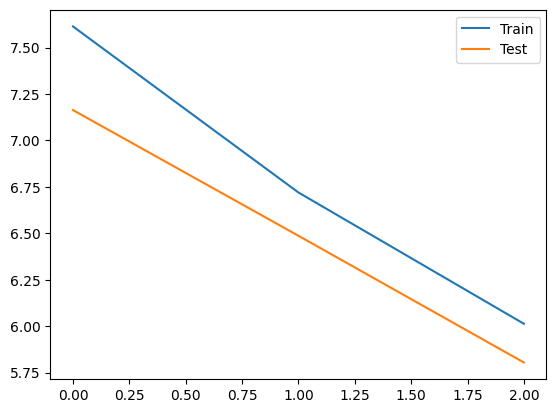

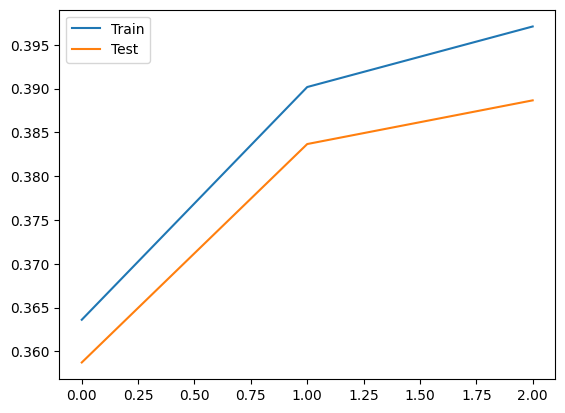

In [ ]:
plt.plot(model.train_loss)
plt.plot(model.test_loss)
plt.legend(["Train", "Test"])
plt.show()

plt.plot(model.train_acc)
plt.plot(model.test_acc)
plt.legend(["Train", "Test"])
plt.show()

In [ ]:
model.save("model.npz")